In [ ]:
# Set the type of this cell to code if you need to add/update packages. Otherwise, leave it how it is.
using Pkg
Pkg.add("NonlinearSolve")
Pkg.add("DifferentialEquations")
Pkg.add("Plots")
Pkg.add("Profile")
Pkg.add("ProfileSVG")

In [1]:
using NonlinearSolve
using DifferentialEquations
using Plots
using Profile # Potentially useless. I tried to profile the solvers but they solve too fast (at least on my machine)
using ProfileSVG

## Using NonlinearSolve.jl to solve for steady state equilibria of prey-predator populations
Models of prey-predator systems are (mostly) expressed as nonlinear differential equations. That is, the population of a prey species (in these models) depends on it's own current population and its predator's current population  A central concept in analyzing these systems is the **steady state** (or **equilibrium**), a population configuration where the populations of prey and predator remain unchanging. Mathematically, these steady states are obtained by setting the time derivatives of the differential equations equal to zero. 

For classical prey-predator models like the Lotka-Volterra equations (which we will be initially using), the steady state often can't be found analytically. Thus, we must use rootfinding, which we can do with `NonlinearSolve.jl`.

### The Lotka-Volterra system
\begin{equation}
\begin{aligned}
\frac{dx}{dt} &= \alpha x - \beta x y, \\
\frac{dy}{dt} &= -\gamma y + \delta x y,
\end{aligned}
\end{equation}
where $\alpha, \beta, \gamma, \delta$ are all parameters relating to death/growth rates, and $x$ and $y$ represent the population density of prey and predators respectively.

In [2]:
function lvNonLinear(u, p) #returns the functions as a tuple, to be used with the NonlinearSolve
    x, y = u
    α, β, γ, δ = p
    
    return [
        α * x - β * x * y,
        -γ * y + δ * x * y
    ]
end

function lvODE!(du, u, p, t) #in place array modification to be used with DifferentialEquations
    x, y = u
    α, β, γ, δ = p
    
    du[1] = α * x - β * x * y
    du[2] = -γ * y + δ * x * y
end;

### Initial parameter test

In [3]:
u0 = [10, 10]
p = [1.1, 0.4, 0.4, 0.1]
tspan = (0.0,100.0); # Not relevant for NonlinearSolve

In [4]:
nonLinearProb = NonlinearProblem(lvNonLinear, u0, p)
nonLinearSol = solve(nonLinearProb, NewtonRaphson(); store_trace=Val(true))

retcode: Success
u: 2-element Vector{Float64}:
 4.0
 2.75

We successfully found the steady state of this prey-predator system with arbitrary initial parameters. \
We can graph the system now with assistance from the `DifferentialEquations.jl` package:

In [5]:
ODEProb = ODEProblem(lvODE!, u0, tspan, p)
ODESol = solve(ODEProb, Rodas5P());

Equilibrium: [4.0, 2.75]


Equilibrium: [4.0, 2.75]


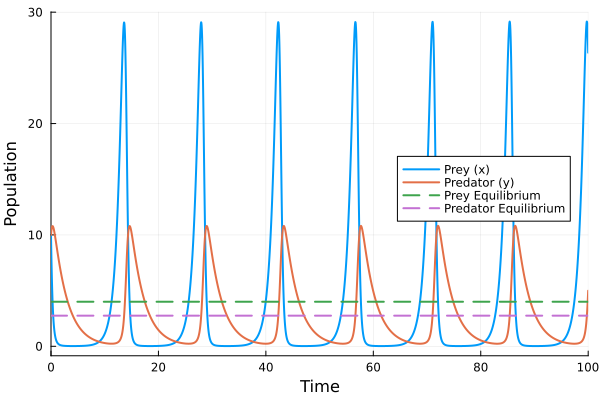

In [6]:
p1 = plot(ODESol, xlabel="Time", ylabel="Population", 
          label=["Prey (x)" "Predator (y)"],
          lw=2, legend=:right)
eq = nonLinearSol.u
println("Equilibrium: ", nonLinearSol.u)
hline!([eq[1]], label="Prey Equilibrium", linestyle=:dash, lw=2)
hline!([eq[2]], label="Predator Equilibrium", linestyle=:dash, lw=2)
plot(p1)

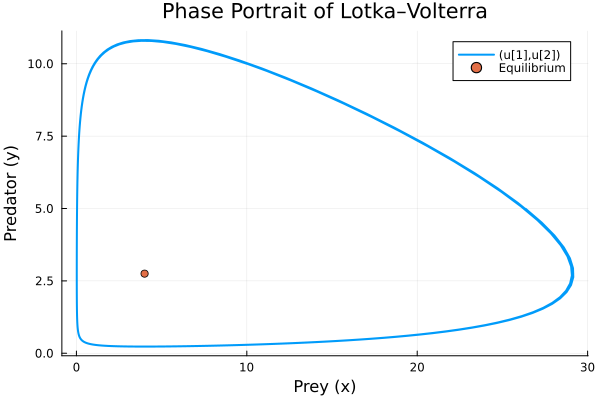

In [7]:
plot(ODESol, idxs=(1,2),
     xlabel="Prey (x)", ylabel="Predator (y)",
     title="Phase Portrait of Lotka–Volterra",
     lw=2)
scatter!([eq[1]], [eq[2]], label="Equilibrium", markersize=4)

Testing it out at the equilibrium:

Equilibrium: [4.0, 2.75]


Equilibrium: [4.0, 2.75]


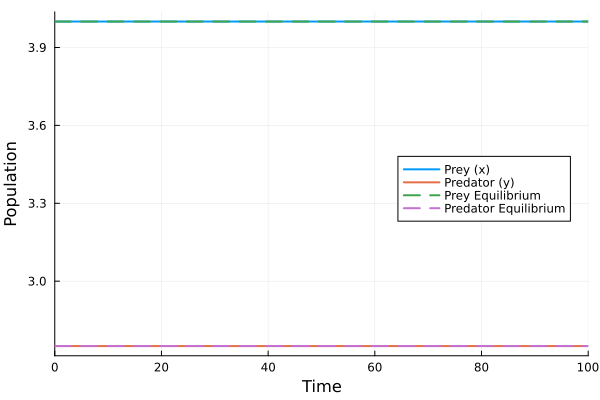

In [8]:
u0 = eq # eq is equilibrium from NonlinearSolve
p = [1.1, 0.4, 0.4, 0.1]
tspan = (0.0,100.0);
ODEProb = ODEProblem(lvODE!, u0, tspan, p)
ODESol = solve(ODEProb, Rodas5P());
p2 = plot(ODESol, xlabel="Time", ylabel="Population", 
          label=["Prey (x)" "Predator (y)"],
          lw=2, legend=:right)
eq = nonLinearSol.u
println("Equilibrium: ", nonLinearSol.u)
hline!([eq[1]], label="Prey Equilibrium", linestyle=:dash, lw=2)
hline!([eq[2]], label="Predator Equilibrium", linestyle=:dash, lw=2)
plot(p2)

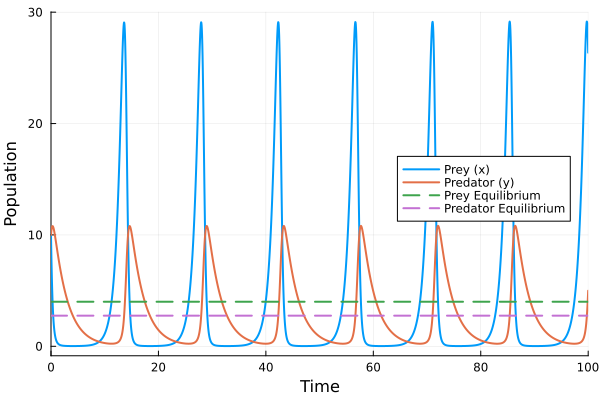

In [9]:
plot(p1) # For comparison. Presentation mode should have this plot and the image below side-by-side

![Image Test](./img/lotkavolterrareal.jpg)

In [10]:
#Profile.init(delay = 0.00005, n = 10^7)

In [11]:
solvers = [
    NewtonRaphson(),
    DFSane(),
    TrustRegion(),
    Broyden(),
]

names = ["NewtonRaphson", "DFSane", "TrustRegion", "Broyden"]

for (name, solver) in zip(names, solvers)
    println("\n Solver: ", name)
    prob = NonlinearProblem(lvNonLinear, u0, p)
    @time sol = solve(prob, solver; store_trace=Val(true))
    # @profview solve(prob, solver; store_trace=Val(true)) # Solve is too fast for profiler to take any samples

    println("Converged: ", sol.retcode == ReturnCode.Success)
    println("Iterations: ", length(sol.trace.history))
    println("Solution: ", sol.u)
end


 Solver: NewtonRaphson
  0.033371 seconds (186.66 k allocations: 10.445 MiB, 99.58% compilation time)
Converged: true
Iterations: 2
Solution: [4.0, 2.75]
  0.033371 seconds (186.66 k allocations: 10.445 MiB, 99.58% compilation time)
Converged: true
Iterations: 2
Solution: [4.0, 2.75]

 Solver: DFSane

 Solver: DFSane
  0.329371 seconds (434.21 k allocations: 22.806 MiB, 99.46% compilation time)
Converged: false
Iterations: 1
Solution: [4.0, 2.75]

 Solver: TrustRegion
  0.329371 seconds (434.21 k allocations: 22.806 MiB, 99.46% compilation time)
Converged: false
Iterations: 1
Solution: [4.0, 2.75]

 Solver: TrustRegion
  0.560099 seconds (1.33 M allocations: 69.975 MiB, 99.87% compilation time)
Converged: true
Iterations: 2
Solution: [4.0, 2.75]

 Solver: Broyden
  0.201138 seconds (497.62 k allocations: 26.682 MiB, 98.17% compilation time)
Converged: true
Iterations: 2
Solution: [4.0, 2.75]
  0.560099 seconds (1.33 M allocations: 69.975 MiB, 99.87% compilation time)
Converged: true
I

## Model 2: Holling Type II Functional Response

The Lotka-Volterra model assumes the predator's consumption rate increases linearly with prey density (unlimited appetite). The **Holling Type II** model introduces **saturation**: predators take time to handle prey, so consumption levels off at high prey densities.

The equations are:
$$
\begin{aligned}
\frac{dx}{dt} &= \alpha x - \frac{\beta x y}{1 + h x} \\
\frac{dy}{dt} &= -\gamma y + \frac{\delta x y}{1 + h x}
\end{aligned}
$$

Where $h$ is the handling time. This nonlinearity can lead to more complex dynamics, such as limit cycles or stable equilibria, and makes finding the equilibrium point more challenging for solvers.

In [49]:
function lv_holling2NonLinear(u,p)
    x,y = u
    α, β, γ, δ, h = p
    denom = 1 + h*x
    return [
        α*x - β*x*y/denom,
        -γ*y + δ*x*y/denom
    ]
end

function lv_holling2!(du,u,p,t)
    x,y = u
    α, β, γ, δ, h = p
    denom = 1 + h*x
    du[1] = α*x - β*x*y/denom
    du[2] = -γ*y + δ*x*y/denom
end

lv_holling2! (generic function with 1 method)

In [60]:
# Parameters for Holling Type II solver comparison
u0_h2 = [2.0, 1.5]
p_h2 = [0.4, 0.4, 0.2, 0.5, 0.05]  # α, β, γ, δ, h - stable parameter set
tspan_h2 = (0.0, 100.0)

(0.0, 100.0)

### Solver Comparison for Holling Type II
We repeat the solver comparison for the Holling Type II model. Again, observe if any solvers fail to find the non-trivial equilibrium.

In [61]:
for (name, solver) in zip(names, solvers)
    println("\n Solver: ", name)
    prob = NonlinearProblem(lv_holling2NonLinear, u0_h2, p_h2)
    @time sol = solve(prob, solver; store_trace=Val(true))

    println("Converged: ", sol.retcode == ReturnCode.Success)
    println("Iterations: ", length(sol.trace.history))
    println("Solution: ", sol.u)
end


 Solver: NewtonRaphson
  0.000070 seconds (128 allocations: 7.453 KiB)
Converged: true
Iterations: 7
Solution: [0.40816326530612246, 1.0204081632653061]

 Solver: DFSane
  0.000016 seconds (216 allocations: 10.938 KiB)
Converged: true
Iterations: 20
Solution: [0.0, -2.061890885313203e-19]

 Solver: TrustRegion
  0.000053 seconds (216 allocations: 12.016 KiB)
Converged: true
Iterations: 11
Solution: [0.4081632653061225, 1.0204081632653061]

 Solver: Broyden
  0.000024 seconds (145 allocations: 7.469 KiB)
Converged: true
Iterations: 12
Solution: [1.0256003152437934e-14, 2.6671731987785245e-14]


### Holling-II Dynamics and Phase Portrait
This section computes the equilibrium and ODE solution for the Holling-II predator–prey model and then produces the time-series dynamics and the phase portrait with the equilibrium marked.

In [62]:
# Holling-II: equilibrium and ODE solution

nonLinearProb_h2 = NonlinearProblem(lv_holling2NonLinear, u0_h2, p_h2)
nonLinearSol_h2 = solve(nonLinearProb_h2, NewtonRaphson())
eq_h2 = nonLinearSol_h2.u
println("Holling-II Equilibrium found: ", eq_h2)

ODEProb_h2 = ODEProblem(lv_holling2!, u0_h2, tspan_h2, p_h2)
ODESol_h2 = solve(ODEProb_h2, Tsit5())

Holling-II Equilibrium found: [0.40816326530612246, 1.0204081632653061]


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 65-element Vector{Float64}:
   0.0
   0.1143483528592656
   0.47599663769506945
   0.9872374824497152
   1.5032631262018747
   2.0806271338797533
   2.769874012919038
   3.4695255223139103
   4.190821859113893
   5.033262424767997
   ⋮
  90.66594813224243
  93.67912003471515
  95.91444578785604
  96.99427281003966
  97.8107803889534
  98.57127182683539
  99.27279649674693
  99.88481422374214
 100.0
u: 65-element Vector{Vector{Float64}}:
 [2.0, 1.5]
 [1.9618348872808373, 1.6252871312701118]
 [1.7775943276803292, 2.0620590202259983]
 [1.38659305159243, 2.71325182418113]
 [0.9494038077870204, 3.2509430244653776]
 [0.5567825767882746, 3.5591923523023974]
 [0.2785319854053679, 3.5517011352791767]
 [0.14192636981435292, 3.3111563524699923]
 [0.0767536112191317, 2.976589056804717]
 [0.04231530734597718, 2.5761984183485738]
 ⋮
 [0.43958672453662373, 0.05185808598699756]
 [1.3635035497561503, 0.09237996206184988]
 [2.

Holling-II Equilibrium: [0.40816326530612246, 1.0204081632653061]


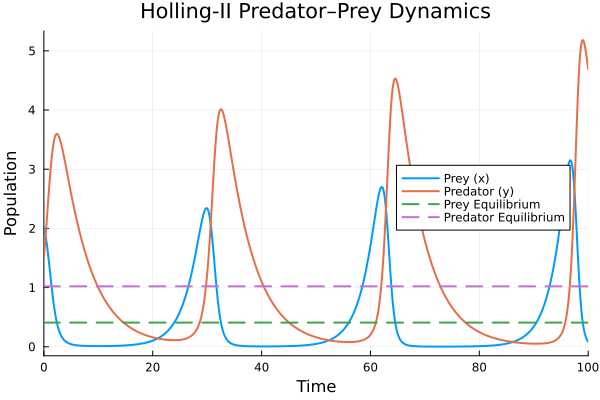

In [63]:
# Holling-II dynamics over time
p_h2_time = plot(ODESol_h2,
    xlabel="Time", ylabel="Population",
    title="Holling-II Predator–Prey Dynamics",
    label=["Prey (x)" "Predator (y)"],
    lw=2, legend=:right)
println("Holling-II Equilibrium: ", eq_h2)
hline!([eq_h2[1]], label="Prey Equilibrium", linestyle=:dash, lw=2)
hline!([eq_h2[2]], label="Predator Equilibrium", linestyle=:dash, lw=2)
plot(p_h2_time)

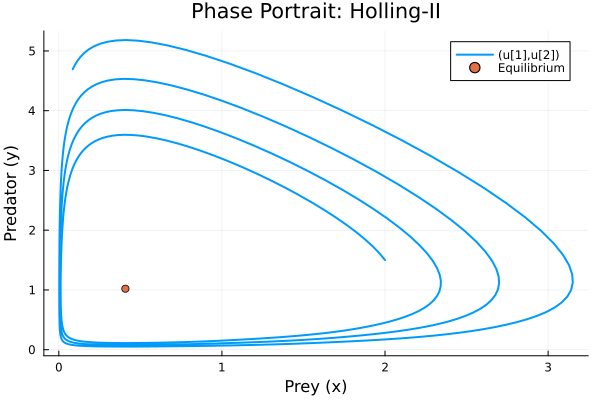

In [64]:
# Holling-II phase portrait
plot(ODESol_h2, idxs=(1,2),
     xlabel="Prey (x)", ylabel="Predator (y)",
     title="Phase Portrait: Holling-II",
     lw=2)
scatter!([eq_h2[1]], [eq_h2[2]], label="Equilibrium", markersize=4)